# Agroscope historical phenotypic spelt data analysis
origin and version of the input file: https://urgi.versailles.inrae.fr/fairdom/data_files/58?version=14

## Load packages, custom functions and data

In [1]:
library(tidyverse)
library(multtest)
library(asreml)

source("../custom_functions.r")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
  

Offline License checked out Wed Dec  4 18:41:01 2024


Loading ASReml-R version 4.2




The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union




The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs




The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min




Loading required package: Biobase



Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.




Loading required package: Matrix




Attaching package: ‘Matrix’




The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




Offline License checked out Fri Nov 22 06:44:55 2024


Loading ASReml-R version 4.2




In [2]:
data_total <- preprocess("Spelt_hist_v6-1-1.xlsx")
write_csv(data_total, "Agroscope_spelt.csv")
genotypes <- distinct(data_total["accenumb"]) |> rename("genotype" = "accenumb")
cat("spelt data:\n", nrow(data_total), "observations\n", nrow(genotypes), "genotypes\n", nrow(distinct(data_total["campaign"])), "campaigns\n\n")
summary(data_total[c("days_to_heading", "plant_height", "thousand_kernel_weight")])

spelt data:
 7513 observations
 375 genotypes
 34 campaigns



 days_to_heading  plant_height    thousand_kernel_weight
 Min.   :144.0   Min.   :  75.0   Min.   : 24.00        
 1st Qu.:161.0   1st Qu.: 135.0   1st Qu.: 35.67        
 Median :171.0   Median : 150.0   Median : 42.80        
 Mean   :168.5   Mean   : 147.3   Mean   : 43.40        
 3rd Qu.:175.0   3rd Qu.: 155.0   3rd Qu.: 48.50        
 Max.   :195.0   Max.   :1160.0   Max.   :109.10        
 NA's   :3567    NA's   :5716     NA's   :6817          

## Subset data, remove missing values and singletons, make factors

In [3]:
data_sub_HT <- data_total |> make_data_sub("days_to_heading", 50, 250)
data_sub_PH <- data_total |> make_data_sub("plant_height", 5, 250)
data_sub_TKW <- data_total |> make_data_sub("thousand_kernel_weight", 5, 100)

2481 days_to_heading rows kept


1589 plant_height rows kept


603 thousand_kernel_weight rows kept


## Visualise trait values 

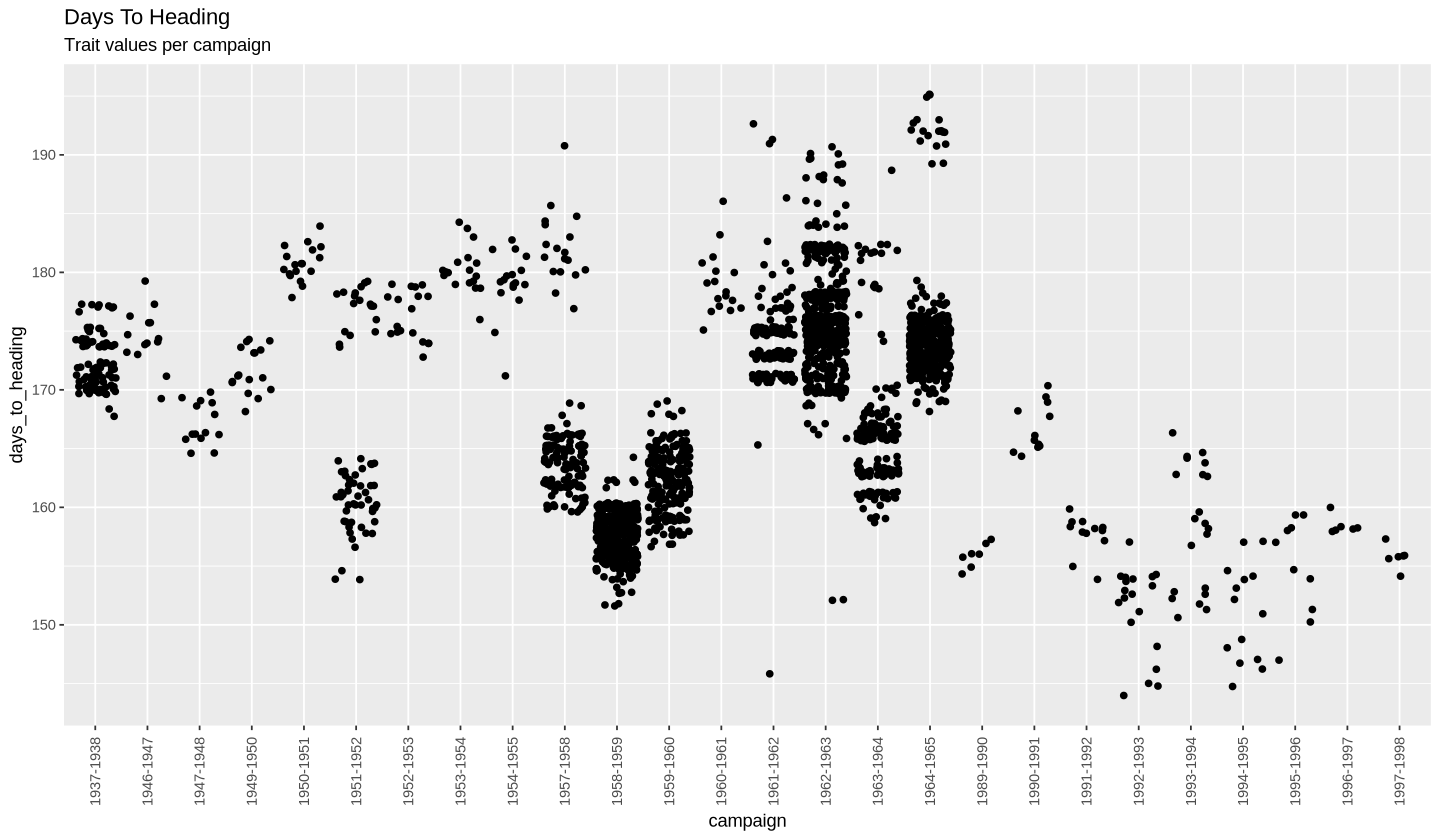

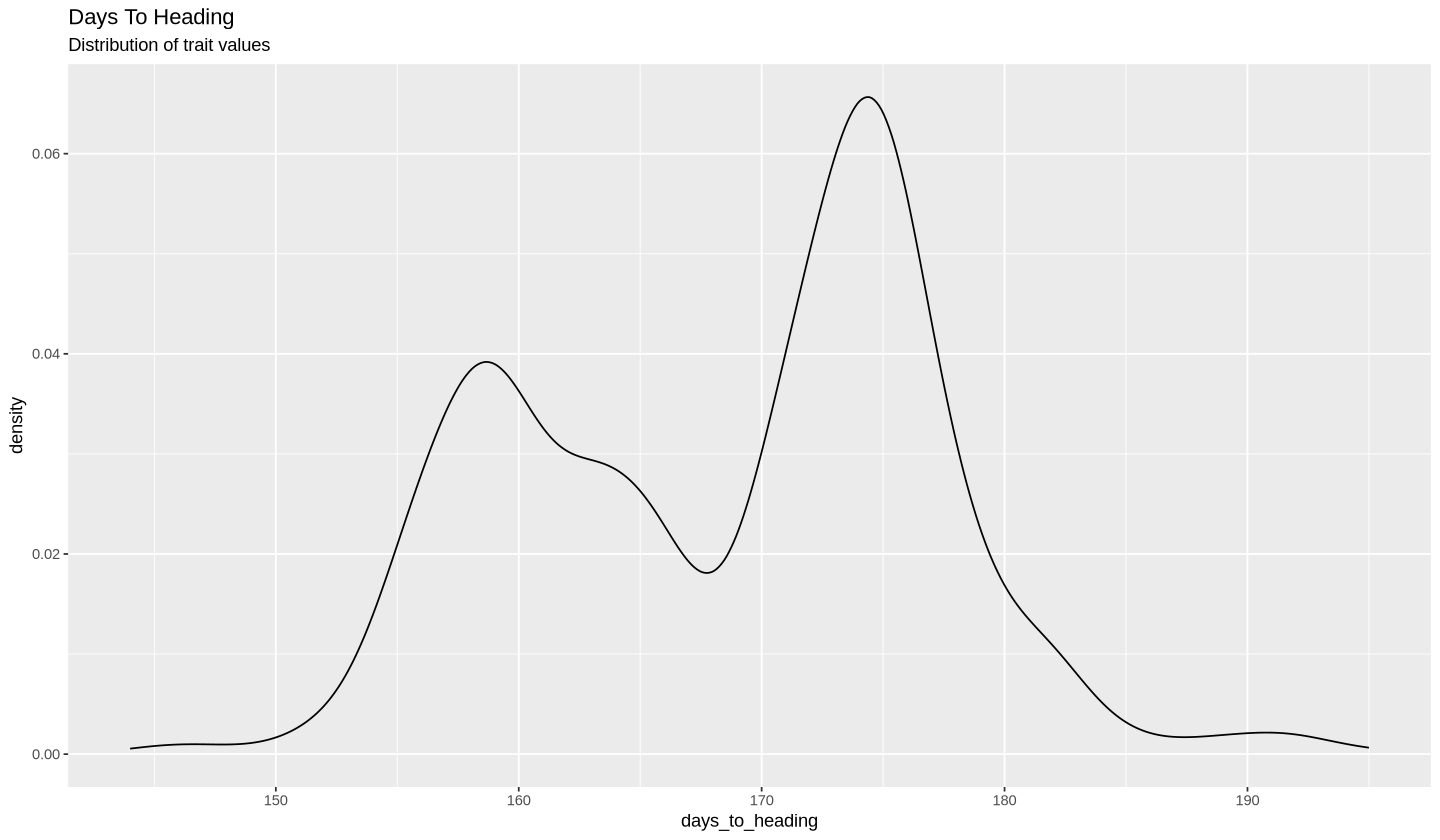

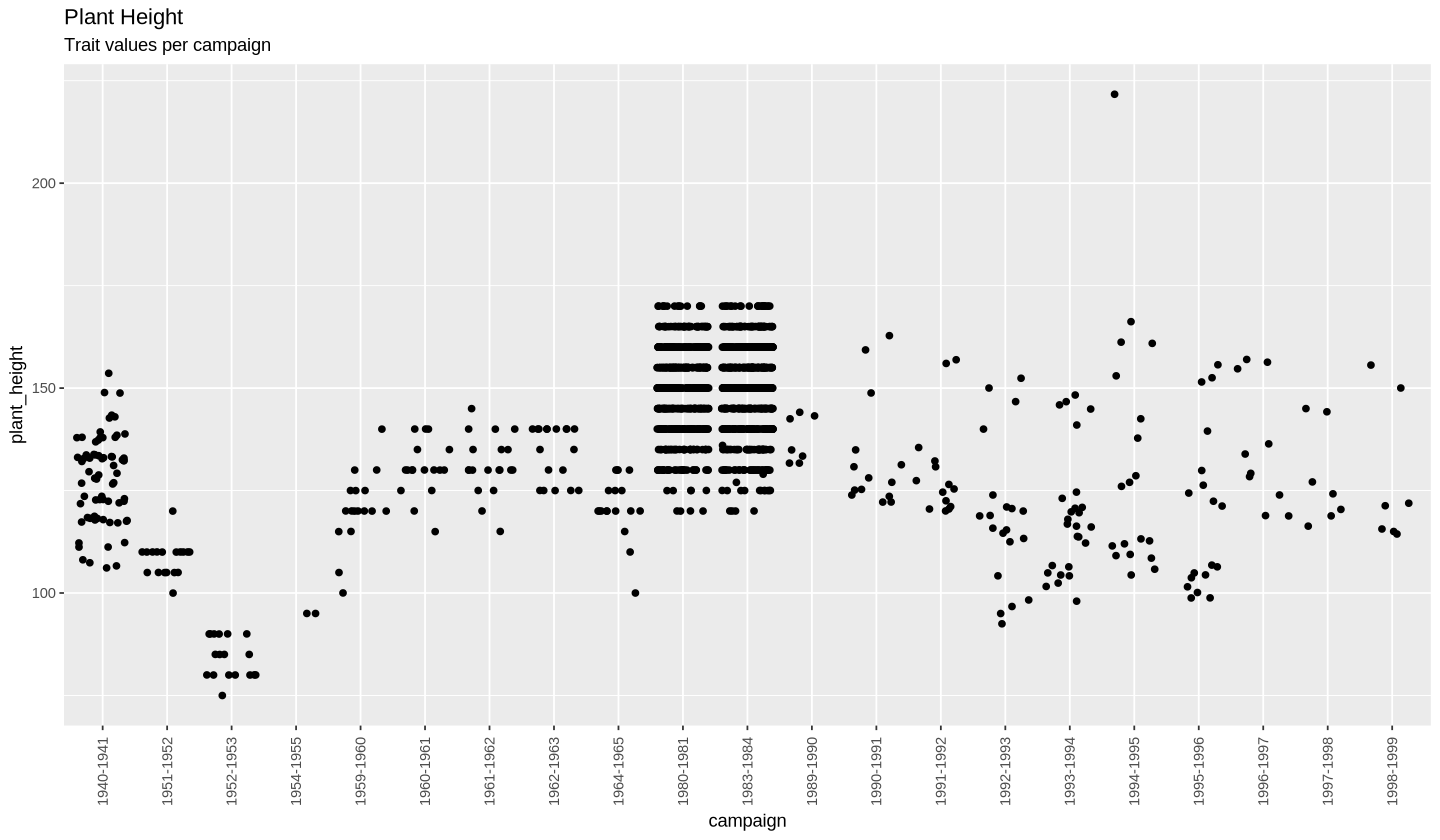

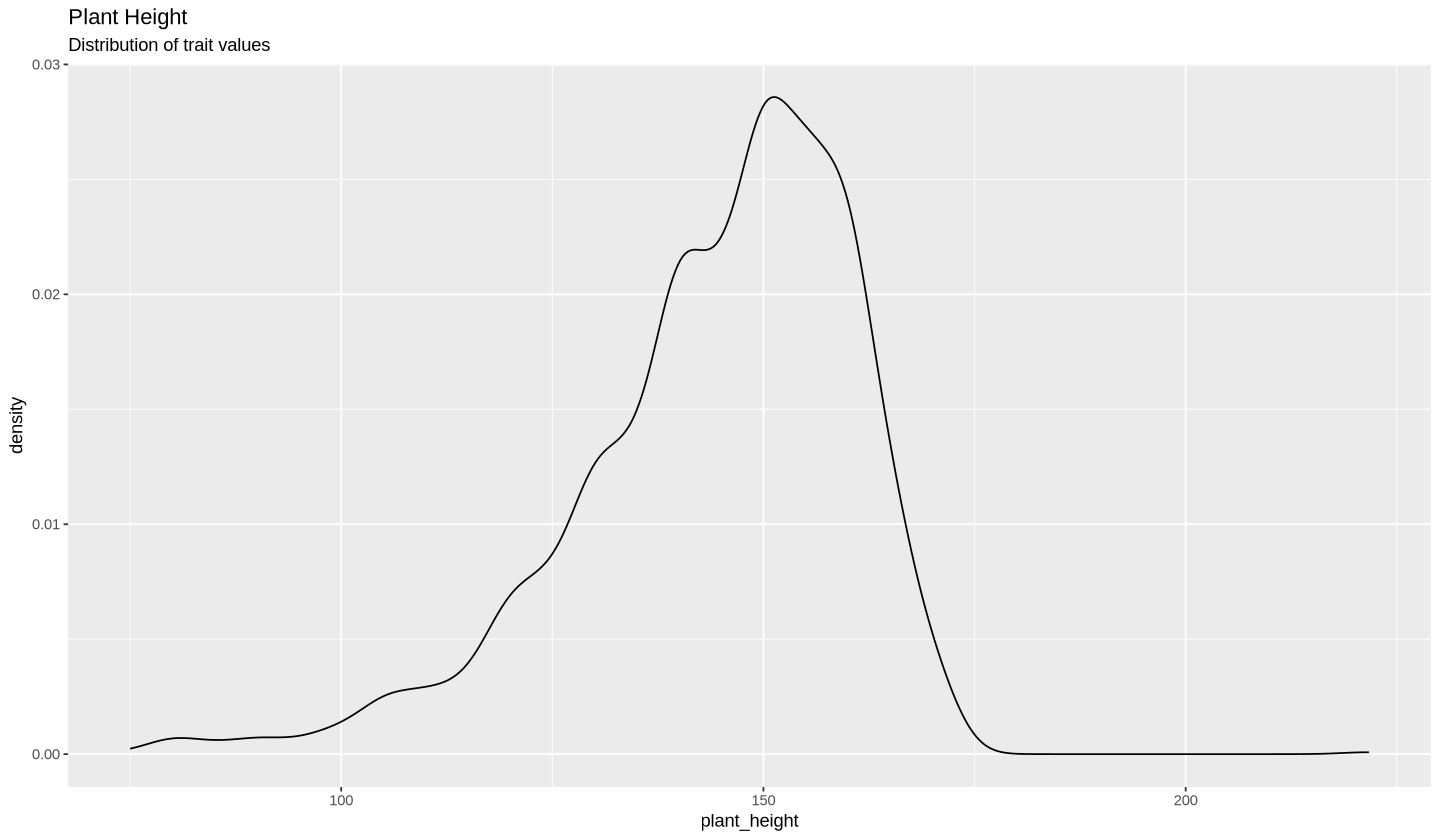

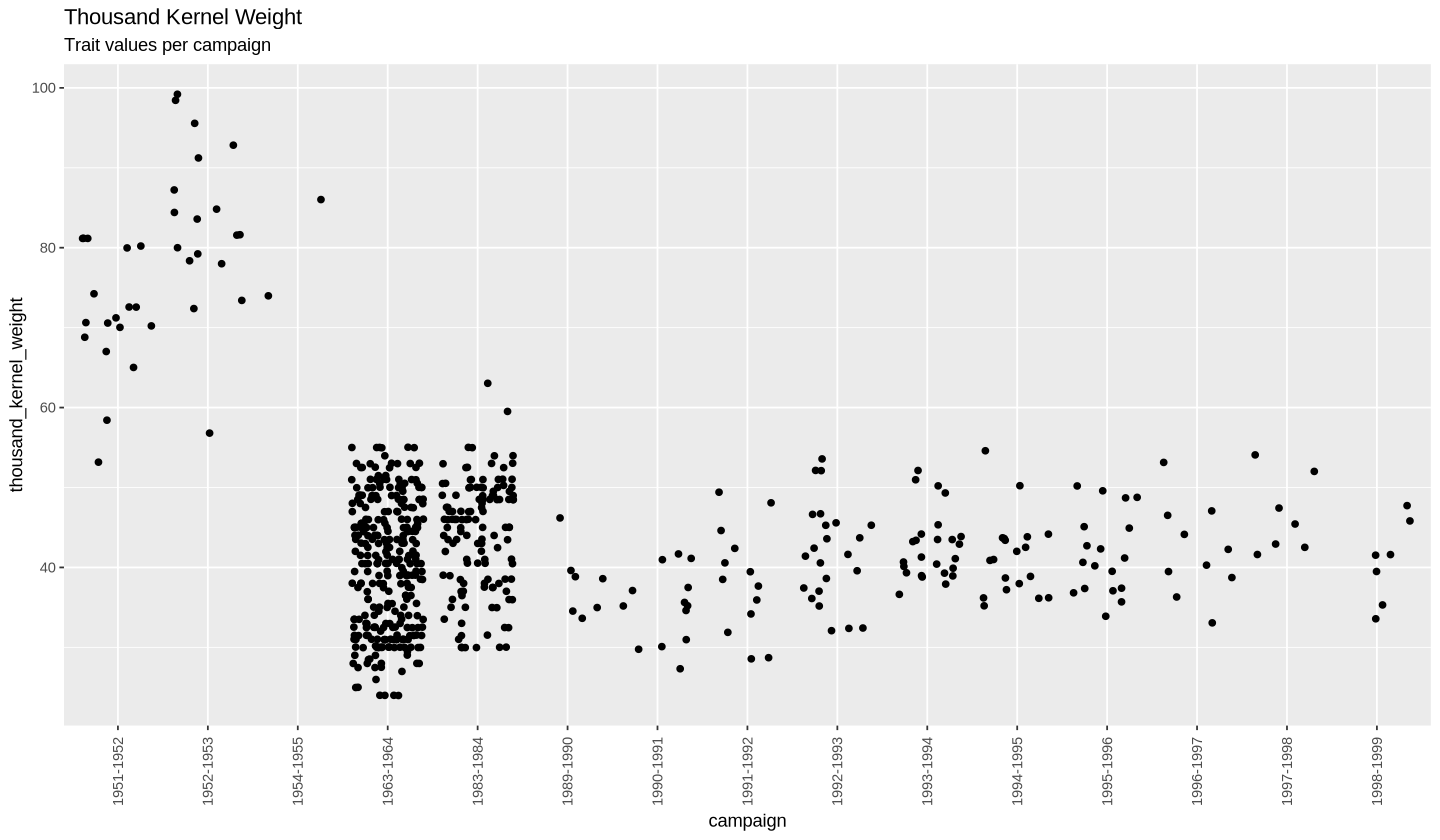

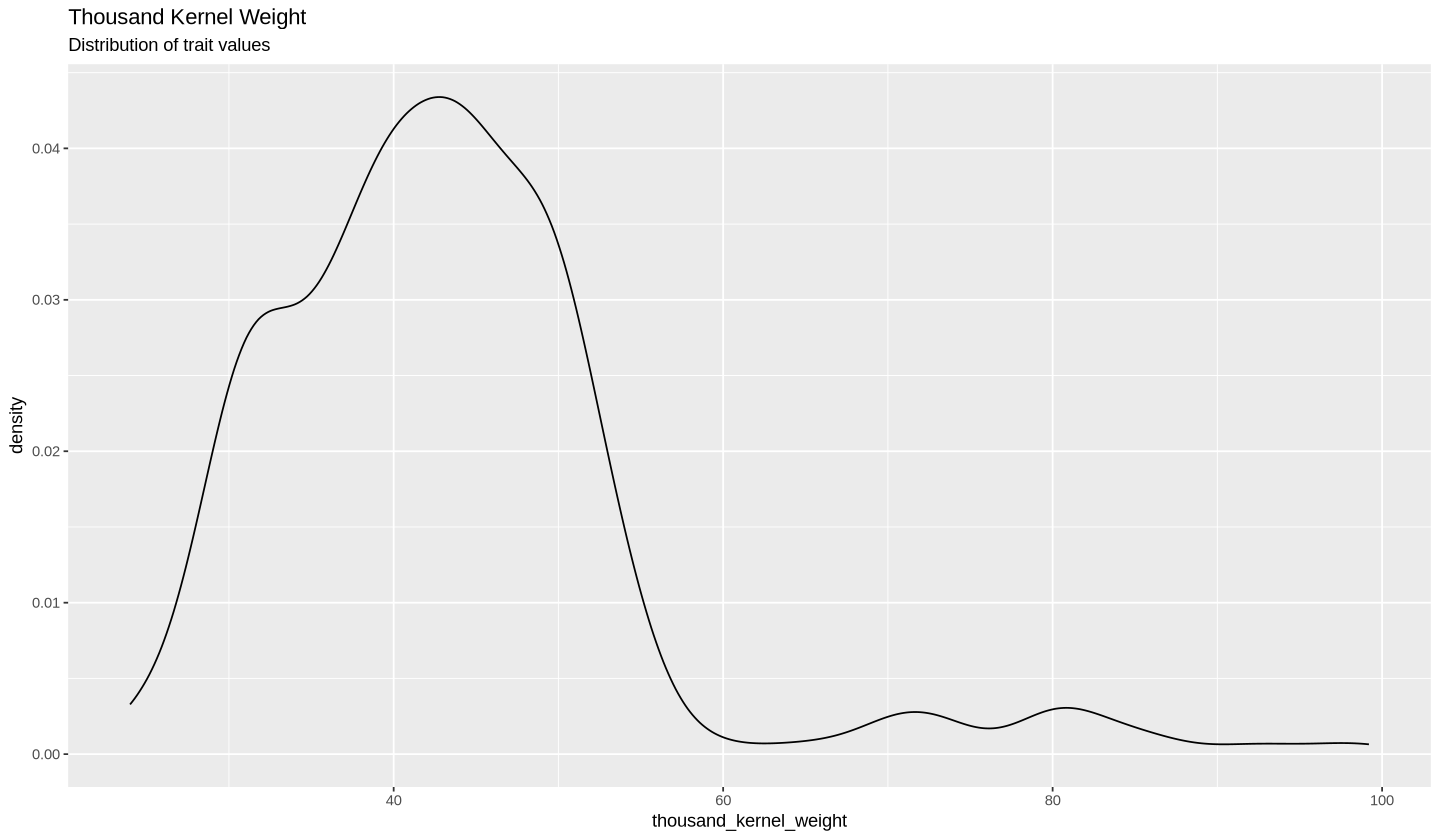

In [4]:
options(repr.plot.width=12, repr.plot.height=7)
data_sub_HT |> visualise_trait(geom_density())
data_sub_PH |> visualise_trait(geom_density())
data_sub_TKW |> visualise_trait(geom_density())

## Extract and format the campaign effects

In [5]:
asreml_campaign_HT <- asreml(fixed = days_to_heading ~campaign, random = ~accenumb, 
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
                             data = data_sub_HT)

In [6]:
data_sub_PH <- data_sub_PH |> remove_lonely(2) # debug asreml
asreml_campaign_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_PH)

In [7]:
asreml_campaign_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_TKW)

Warning message in asreml(fixed = thousand_kernel_weight ~ campaign, random = ~accenumb, :
“Log-likelihood not converged”


In [8]:
campaign_effect_HT <- get_campaign_effect(asreml_campaign_HT)
campaign_effect_PH <- get_campaign_effect(asreml_campaign_PH)
campaign_effect_TKW <- get_campaign_effect(asreml_campaign_TKW)

## Extract heterogeneous error variances

In [9]:
error_var_HT <- get_error_var(asreml_campaign_HT)
error_var_PH <- get_error_var(asreml_campaign_PH)
error_var_TKW <- get_error_var(asreml_campaign_TKW)

## Calculate and standardize the coefficient of variation (CV)

In [10]:
CV_df_HT <- make_CV_df(campaign_effect_HT, error_var_HT)
CV_df_PH <- make_CV_df(campaign_effect_PH, error_var_PH)
CV_df_TKW <- make_CV_df(campaign_effect_TKW, error_var_TKW)

## Remove outlier campaigns

In [11]:
data_corrected_HT_I <- data_sub_HT |> correct_I(CV_df_HT)
data_corrected_PH_I <- data_sub_PH |> correct_I(CV_df_PH)
data_corrected_TKW_I <- data_sub_TKW |> correct_I(CV_df_TKW)

0 outlier campaign(s) detected for trait days_to_heading


1 outlier campaign(s) detected for trait plant_height: 1994-1995 


0 outlier campaign(s) detected for trait thousand_kernel_weight


## Residuals

In [12]:
asreml_res_HT <- asreml(fixed = days_to_heading ~ accenumb, random = ~ campaign,
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_HT_I)

In [13]:
asreml_res_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_PH_I)

In [14]:
asreml_res_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_TKW_I)

16 outlier value(s) detected for trait Days To Heading 


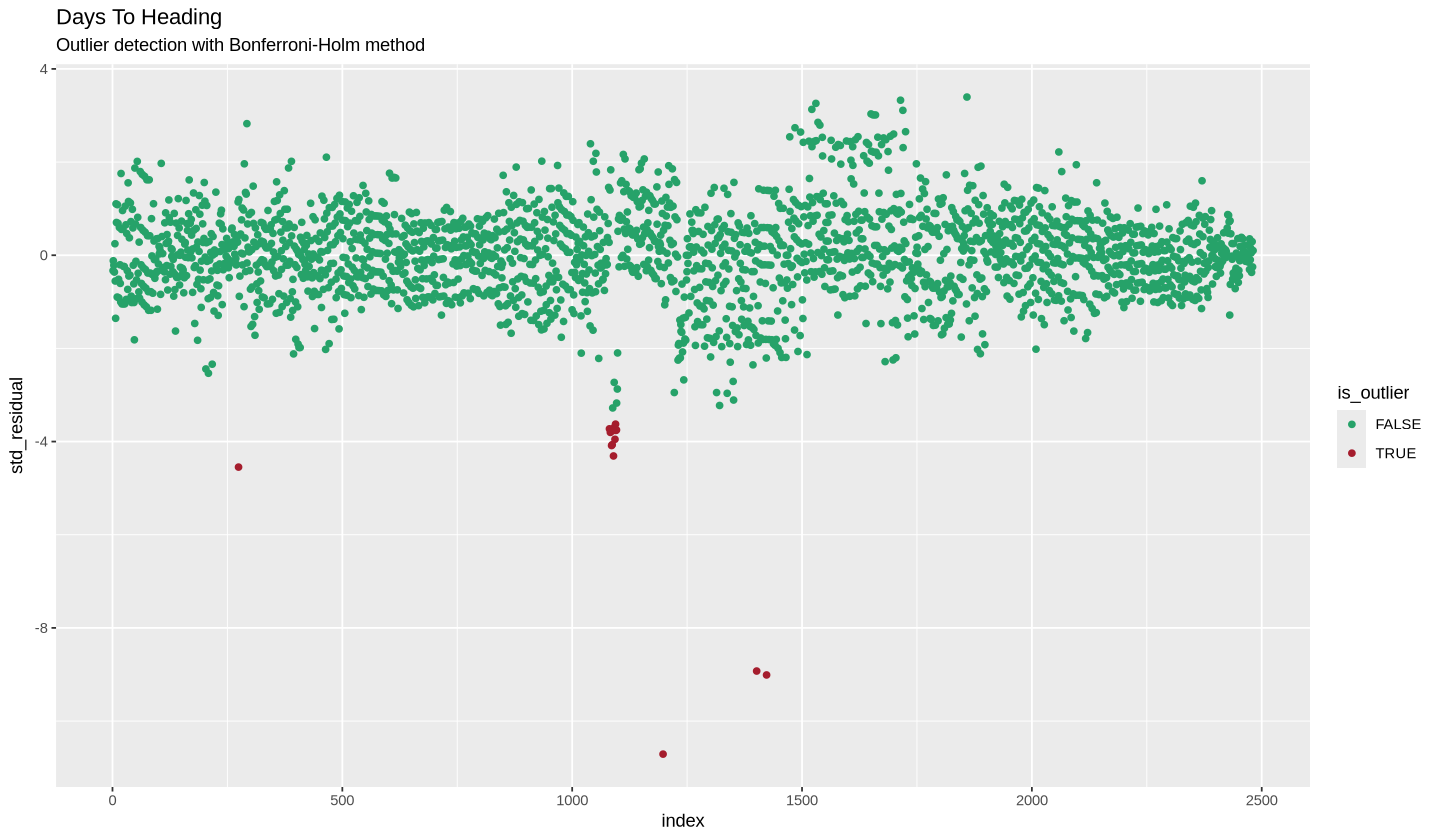

In [15]:
result_BH_HT <- make_BH_multtest(asreml_res_HT)

0 outlier value(s) detected for trait Plant Height 


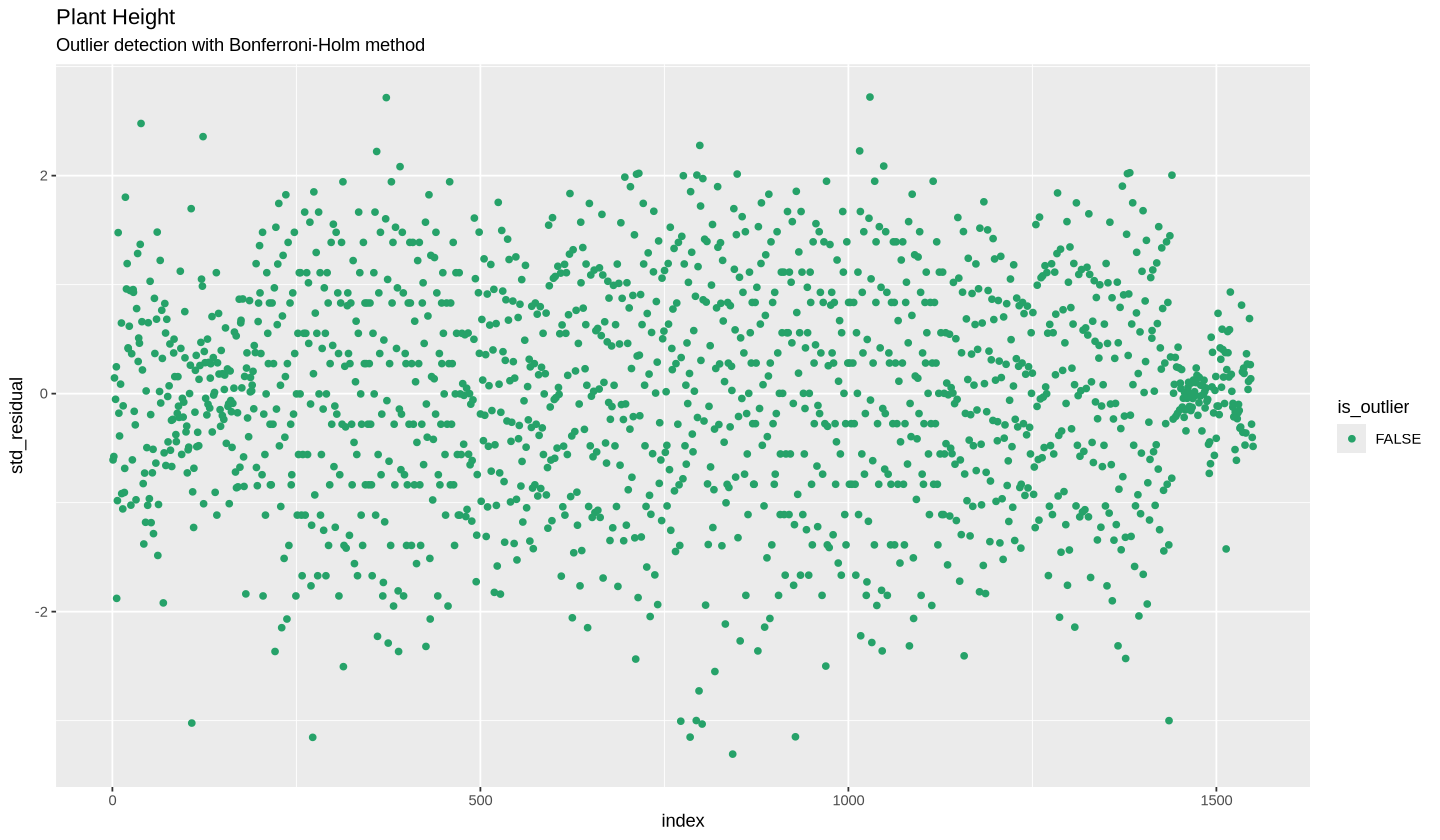

In [16]:
result_BH_PH <- make_BH_multtest(asreml_res_PH)

1 outlier value(s) detected for trait Thousand Kernel Weight 


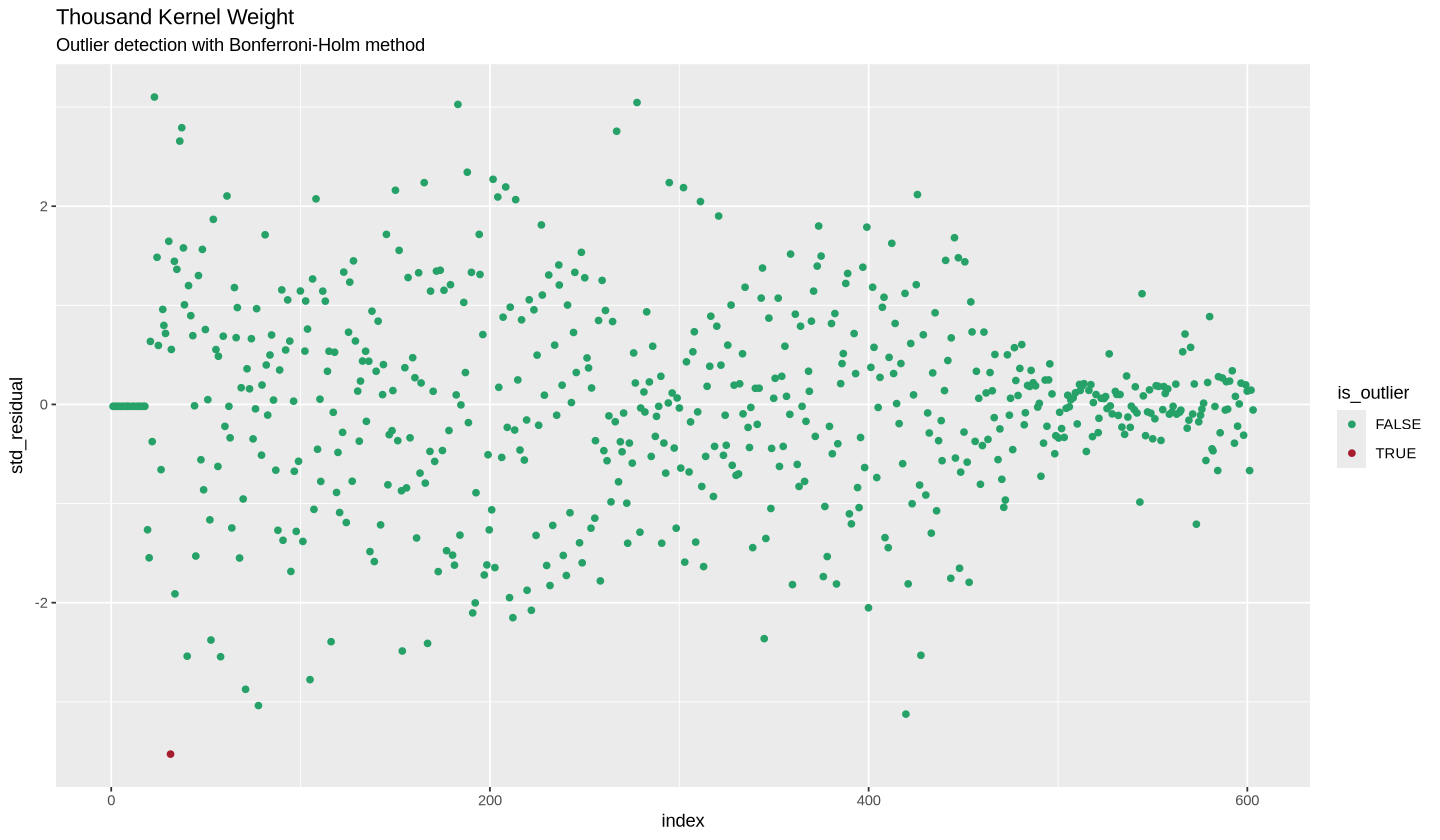

In [17]:
result_BH_TKW <- make_BH_multtest(asreml_res_TKW)

In [18]:
data_corrected_HT_II <- data_corrected_HT_I |> correct_II(result_BH_HT)
data_corrected_PH_II <- data_corrected_PH_I |> correct_II(result_BH_PH)
data_corrected_TKW_II <- data_corrected_TKW_I |> correct_II(result_BH_TKW)

In [19]:
data_corrected_all <- bind_rows(
    data_corrected_HT_II,
    data_corrected_PH_II,
    data_corrected_TKW_II,
    ) |> pivot_longer(cols = !c(accenumb,campaign), names_to = "trait") |>
         drop_na() |> arrange(campaign, accenumb, trait)
write_csv(data_corrected_all, "Agroscope_spelt_corrected.csv")

## Calculate heritability

In [20]:
asreml_res_h_HT <- asreml(days_to_heading ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_HT_II)

Warning message in asreml(days_to_heading ~ 1, random = ~accenumb + campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


In [21]:
asreml_res_h_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PH_II)

In [22]:
asreml_res_h_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"),
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_TKW_II)

In [23]:
quality_HT <- get_quality(data_sub_HT, asreml_res_h_HT)
quality_PH <- get_quality(data_sub_PH, asreml_res_h_PH)
quality_TKW <- get_quality(data_sub_TKW, asreml_res_h_TKW)
quality_all <- bind_rows(quality_HT, 
                         quality_PH, 
                         quality_TKW) |> mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_all,"Agroscope_spelt_data_quality.csv")

days_to_heading heritability: 98.9 %


plant_height heritability: 92 %


thousand_kernel_weight heritability: 66.6 %


## Run linear mixed model with outlier corrected data

In [24]:
asreml_data_HT <- asreml(days_to_heading ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_HT_II)

In [25]:
asreml_data_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PH_II)

In [26]:
asreml_data_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
                          na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                          data = data_corrected_TKW_II)

Warning message in asreml(thousand_kernel_weight ~ accenumb, random = ~campaign, :
“Log-likelihood not converged”


Warning message in asreml(thousand_kernel_weight ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration”


## Extract BLUEs and create output file

In [27]:
BLUEs_HT <- get_BLUEs(asreml_data_HT)
BLUEs_PH <- get_BLUEs(asreml_data_PH)
BLUEs_TKW <- get_BLUEs(asreml_data_TKW)

BLUE_all <- genotypes |> 
                        left_join(BLUEs_HT, by="genotype") |> 
                        left_join(BLUEs_PH, by="genotype") |> 
                        left_join(BLUEs_TKW, by="genotype") |> 
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_all,"Agroscope_spelt_BLUE_values.csv")
summary(BLUE_all)

   genotype         days_to_heading_BLUE plant_height_BLUE
 Length:375         Min.   :147.4        Min.   : 97.71   
 Class :character   1st Qu.:162.4        1st Qu.:134.67   
 Mode  :character   Median :163.4        Median :142.15   
                    Mean   :163.8        Mean   :137.88   
                    3rd Qu.:164.1        3rd Qu.:145.43   
                    Max.   :183.5        Max.   :155.02   
                    NA's   :161          NA's   :205      
 thousand_kernel_weight_BLUE
 Min.   :29.23              
 1st Qu.:37.62              
 Median :42.27              
 Mean   :46.77              
 3rd Qu.:47.25              
 Max.   :87.86              
 NA's   :275                

In [28]:
library(rmarkdown)
convert_ipynb("WBF-Agroscope_historic_spelt_data_analysis.ipynb")

In [29]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 24.04.1 LTS

Matrix products: default
BLAS/LAPACK: /home/erwan/micromamba/envs/R/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Paris
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rmarkdown_2.29      asreml_4.2.0.267    Matrix_1.6-5       
 [4] multtest_2.58.0     Biobase_2.62.0      BiocGenerics_0.48.1
 [7] lubridate_1.9.3     forcats_1.0.0       stringr_1.5.1      
[10] dplyr_1.1.4         purrr_1.0.2